# Grokking Stable Diffusion

I've been playing with stable diffusion (who hasn't) and starting to think about how to structure learning material about diffusion models. This notebook is basically a tidier version of my first dabble with the model, trying to understand ('grok') the individual parts and to think about how they could be presented as part of a lesson. 

This will eventually turn into a more polished component of a larger course, but I can't resist sharing this now for everyone else trying to hack around with this cool new toy. Feel free to contact me @johnowhitaker with questions or join the AIAIART discord (link is in the readme of https://github.com/johnowhitaker/aiaiart) where we'll chat about this (and maybe do a video walkthrough in a few days).

OK enough intro, have fun and happy hacking :)

PS: A more up-to-date version of this in on GitHub here: https://github.com/fastai/diffusion-nbs/blob/master/Stable%20Diffusion%20Deep%20Dive.ipynb - updated for the latest version of the diffusers library and featuring some extra bits. Keeping this version as-is since it was a temporary dev notebook. It's final form will be lesson 14 of my new course out in November.

## Setup & Imports

Here we install the library, log into HF (you'll need to accept the licence terms to download the model) and import some things we'll need for the demos.

In [ ]:
!pip install transformers diffusers==0.2.4 # For now specific version needed as update broke something

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.0/113.0 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 101.6 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

## Loading the models

This code (and that in the next section) comes from the [Huggingface example notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb). 

This will download and set up the relevant models and components we'll be using. Let's just run this for now and move on to the next section to check that it all works before diving deeper.

In [ ]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.1.layer_norm1.weight', 'vision_model.encoder.layers.12.self_attn.out_proj.weight', 'vision_model.encoder.layers.22.self_attn.out_proj.weight', 'vision_model.encoder.layers.15.layer_norm2.bias', 'vision_model.encoder.layers.16.self_attn.v_proj.weight', 'vision_model.encoder.layers.7.layer_norm2.bias', 'vision_model.encoder.layers.13.self_attn.q_proj.weight', 'vision_model.encoder.layers.20.mlp.fc1.bias', 'vision_model.post_layernorm.bias', 'vision_model.encoder.layers.6.self_attn.out_proj.bias', 'vision_model.encoder.layers.9.layer_norm2.weight', 'vision_model.encoder.layers.5.self_attn.q_proj.bias', 'vision_model.encoder.layers.23.self_attn.k_proj.bias', 'vision_model.encoder.layers.17.mlp.fc1.bias', 'vision_model.encoder.layers.6.self_attn.k_proj.bias', 'vision_model.encoder.layers.6.mlp.fc2.bias', 'vision_model.encoder.layers.16.layer_norm

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

## A diffusion loop

Again, right now we're basically just running the code from the [HF notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb). 

If this is all you want, you could ignore this notebook and use one of the existing tools (such as [DreamStudio](https://beta.dreamstudio.ai/)) or use the simplified pipeline from huggingface, as documented [here](https://huggingface.co/blog/stable_diffusion).

What we want to do in this notebook is dig a little deeper into how this works, so we'll start by checking that the example code runs:

0it [00:00, ?it/s]

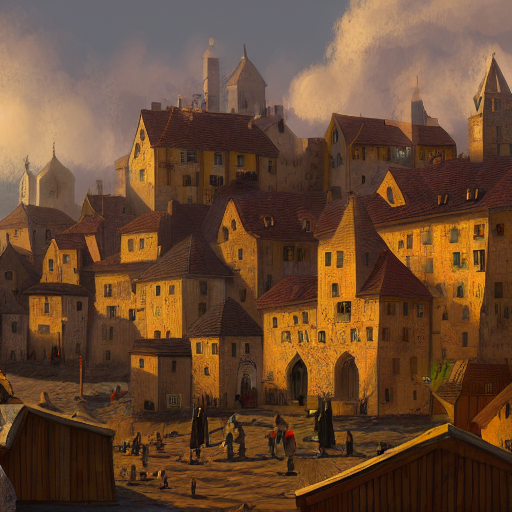

In [ ]:
# Some settings
prompt = ["""A digital illustration of a medieval town, 4k detailed, trending on artstation, fantasy"""]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text 
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents)
  
# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

It works, but what does it all mean? Let's look at the different components here one by one.

## The AutoEncoder (AE)

The AE can 'encode' and image into some sort of latent representation, and decode this back into an image. I've wrapped the code for this into a couple of functions here so we can see what this looks like in action:

In [ ]:
# Using torchvision.transforms.ToTensor
to_tensor_tfm = tfms.ToTensor()

def pil_to_latent(input_im):
  # Single image -> single latent in a batch (so size 1, 4, 64, 64)
  with torch.no_grad():
    latent = vae.encode(to_tensor_tfm(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
  return 0.18215 * latent.mode() # or .mean or .sample

def latents_to_pil(latents):
  # bath of latents -> list of images
  latents = (1 / 0.18215) * latents
  with torch.no_grad():
    image = vae.decode(latents)
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

We'll use a pic from the web here, but you can load your own instead by uploading it and editing the filename in the following code. 

In [ ]:
# Download a demo Image
!curl --output macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62145  100 62145    0     0  47877      0  0:00:01  0:00:01 --:--:-- 47877


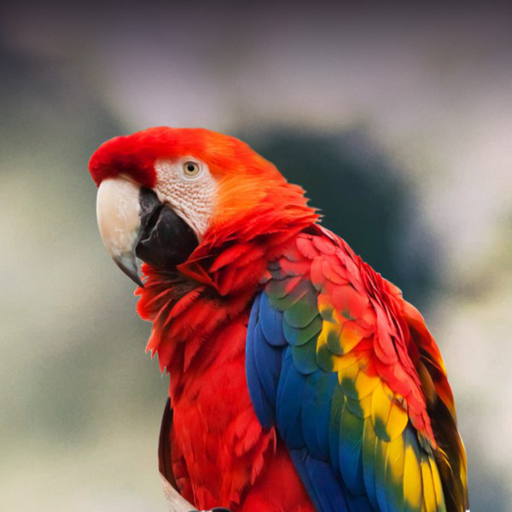

In [ ]:
# Load the image with PIL
input_image = Image.open('macaw.jpg').resize((512, 512))
input_image

Encoding this into the latent space of the AE with the finction defined above looks like this:

In [ ]:
# Encode to the latent space
encoded = pil_to_latent(input_image)
encoded.shape

torch.Size([1, 4, 64, 64])

We can do the reverse as well, going fom the latent representation back to an image:

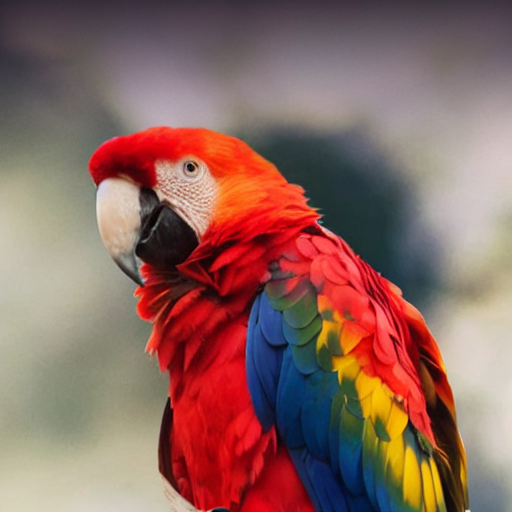

In [ ]:
# Decode this latent representation back into an image
decoded = latents_to_pil(encoded)[0]
decoded

You'll see some small differences if you squint! Forcus on the eye if you can't see anything obvious. This is pretty impressive - that 4x64x64 latent seems to hold a lot more information that a 64px image...

This autoencoder has been trained to squish down an image to a smaller representation and then re-create the image back from this compressed version again.

In this particular case, it does so by a factor of ~8 (512 / 8 = 64), so each 8x8px patch gets compressed down to four numbers (the four channels in the AE output). You can find AEs with a higher compression ratio (eg f16 like some popular VQGAN models) but at some point they begin to introduce artifacts that we don't want.

Why do we even use an autoencoder? We can do diffusion in pixel space - where the model gets all the image data as inputs and produces an output prediction of the same shape. But this means processing a LOT of data, and make high-resolution generation very computationally expensive. Some solutions to this involve doing diffusion at low resolution (64px for eg) and then trsaining a separate model to upscale repeatedly (as with D2/Imagen). But latent diffusion instead does the diffusion process in this 'latent space', using the compressed representations from our AE rather than raw images. These representations are information rich, and can be small enough to handle manageably on consumer hardware. Once we've generated a new 'image' as a latent representation, the autoencoder can take those final latent outputs and turn them into actual pixels. 

## The Scheduler

Now we need to talk about adding noise...

During training, we add some noise to an image an then have the model try to predict the noise. If we always added a ton of noise, the model might not have much to work with. If we only add a tiny amount, the model won't be able to do much with the random starting points we use for sampling. So during training the amount is varied, according to some distribution. 

During sampling, we want to 'denoise' over a number of steps. How many steps and how much noise we should aim for at each step are going to affect the final result. 

The scheduler is in charge of handling all of these details. For eg:
`scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)` sets up a scheduler that matches the one used to train this model. When we want to sample over a smaller number of steps, we set this up with `scheduler.set_timesteps`:

In [ ]:
# Setting the number of sampling steps:
scheduler.set_timesteps(15)

You can see how our new set of steps corresponds to those used in training:

In [ ]:
# See these in terms of the original 1000 steps used for training:
print(scheduler.timesteps)

tensor([999.0000, 927.6429, 856.2857, 784.9286, 713.5714, 642.2143, 570.8571,
        499.5000, 428.1429, 356.7857, 285.4286, 214.0714, 142.7143,  71.3571,
          0.0000], dtype=torch.float64)


And how much noise is present at each:

In [ ]:
# Look at the equivalent noise levels:
print(scheduler.sigmas)

tensor([14.6147,  9.6826,  6.6780,  4.7746,  3.5221,  2.6666,  2.0606,  1.6156,
         1.2768,  1.0097,  0.7913,  0.6056,  0.4397,  0.2780,  0.0292,  0.0000],
       dtype=torch.float64)


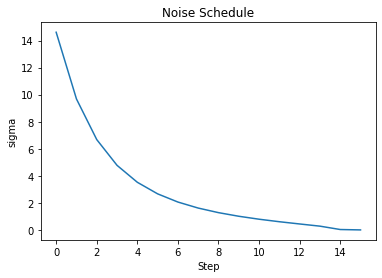

In [ ]:
#@markdown Plotting this noise schedule:
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Step')
plt.ylabel('sigma')
plt.show()

This 'sigma' is the amount of noise added to the latent representation. Let's visualize what this looks like by adding a bit of noise to our encoded image and then decoding this noised version:

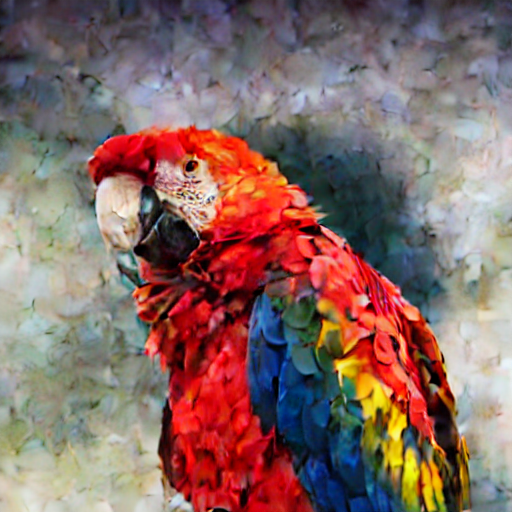

In [ ]:
# View a noised version
noise = torch.randn_like(encoded) # Random noise
timestep = 150 # i.e. equivalent to that at 150/1000 training steps
encoded_and_noised = scheduler.add_noise(encoded, noise, timestep)
latents_to_pil(encoded_and_noised)[0] # Display

What does this look like at t=300, 500 or 999? Try it out and see :)

## Loop starting from noised version of input

Let's see what happens when we use our image as a starting point, adding some noise and then doing the final few denoising steps in the loop with a new prompt.

We'll use a similar loop to the first demo, but we'll skip the first 'start_step' steps.

To noise our image we'll use code like that shown above, with `timestep = int(scheduler.timesteps[start_step])` to add the right amount of noise. You could of course tweak this to be independant of start_steps, but it seems to best when you follow the schedule.

0it [00:00, ?it/s]

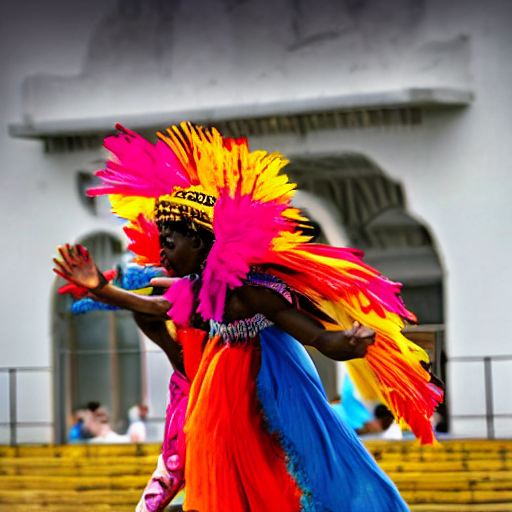

In [ ]:
#@title re-generate starting from a noised version of this image
prompt = ["A colorful dancer, nat geo photo"] #@param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #@param           # Number of denoising steps
guidance_scale = 8                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text 
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Start step
start_step = 10 #@param Explore ;)
start_sigma = scheduler.sigmas[start_step]
start_timestep = int(scheduler.timesteps[start_step])

# Prep latents
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, start_timestep)
latents = latents.to(torch_device)
latents = latents * start_sigma  # << NB

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    if i > start_step:
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

latents_to_pil(latents)[0]

You can see that some colours and structure from the image are kept, but we now have a new picture! The more noise you add and the more steps you do, the further away it gets from the input image. 

This is how the popular img2img pipeline works. Again, if this is your end goal there are tools to make this easy!

But you can see that under the hood this is the same as the generation loop just skipping the first few steps and starting from a noised image rather than pure noise.

# The Text Encoder

How do our captions get turned into something the model can use to produce images?

We rely on a text encoder - usually a transformer model. In this case, SD uses one of openai's CLIP text encoders. Since CLIP was trained to find relationships between text and images, the hope is that this model has learnt to map text to very rich representations which we can use. 

Let's walk through th precess of moving from text to a set of embeddings we can feed to our diffusion model:

In [ ]:
# Let's start with a prompt
prompt = 'Cave painting of a bird, flooble'

In [ ]:
# First step is to convert this into a sequence of tokens
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids'][0] # View the tokens

tensor([49406,  9654,  3086,   539,   320,  3329,   267,  4062,  1059, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

There are some special tokens in here, as well as tokens representing our input. Most are just `49407`, which is a special padding token. Many words get their own token, but for unknown words like 'flooble' the tokenizer splits them up. We can decode one token at a time to see how the tokenizer has interpreted our input:

In [ ]:
# Decode the first non-special token
tokenizer.decoder.get(9654)

'cave</w>'

In [ ]:
# And the last two non-pad tokens:
print(4062, tokenizer.decoder.get(4062))
print(1059, tokenizer.decoder.get(1059))

4062 floo
1059 ble</w>


Now that we have a fixed-length input of tokens, the next step is to convert these into *embeddings*. There is some confusing terminology here, so to clarify:

when the tokens are first passed to the text model, a set of learned embeddings is used to create a vector from each token. This are the model's input embeddings. These input embeddings are then fed through the text model (a transformer) which outputs a new set of embeddings. It is these output embeddings that we're using and talking about, and thanks to the magic of attention and transformers they hopefully capture a richer set of semantic meanings that incorporate the context of the prompt as a whole better than a discreet set of word embeddings would. 

This is what the final embeddings look like:

In [ ]:
# Grab the embeddings
embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
print('Shape:', embeddings.shape)
embeddings

Shape: torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.1967,  0.3905, -1.1450,  ..., -0.9653,  2.0285,  0.2323],
         [-0.1163,  0.4147, -1.2173,  ..., -0.6865, -0.3320,  1.5457],
         ...,
         [-0.3868, -0.0672, -0.0636,  ..., -1.5762,  0.1958, -0.1945],
         [-0.3894, -0.0515, -0.0919,  ..., -1.5772,  0.2131, -0.1897],
         [-0.3998, -0.0703,  0.0162,  ..., -1.5541,  0.2430, -0.1985]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

For every token in the 77-token input we have a 768-dimensional representation. These capture a lot of *meaning* about the input string, and the hope is that this gives the diffusion model as much chance as possible to use this info in the denoising task.

To have a bit of fun with this, let's embed two inputs and take the average as our final embedding, and see what kind of image that results in:. We can control how much of each we include with a `mix_factor`.

0it [00:00, ?it/s]

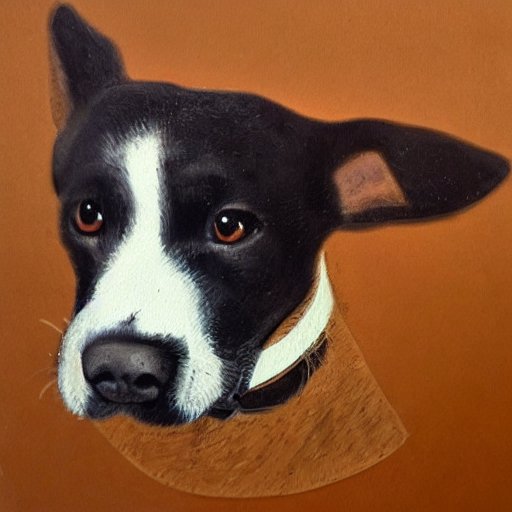

In [ ]:
#@title re-generate starting from a noised version of this image
prompt1 = 'A dog' #@param
prompt2 = 'A pencil' #@param
mix_factor = 0.4 #@param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #@param           # Number of denoising steps
guidance_scale = 8                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text 
# Embed both prompts
text_input1 = tokenizer([prompt1], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings1 = text_encoder(text_input1.input_ids.to(torch_device))[0]
text_input2 = tokenizer([prompt2], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings2 = text_encoder(text_input2.input_ids.to(torch_device))[0]
# Take the average
text_embeddings = (text_embeddings1*mix_factor + \
                   text_embeddings2*(1-mix_factor))
# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

latents_to_pil(latents)[0]

You can do this in other ways (for example, combining words by messing with individual token embeddings) but even this rough demo is quite fun! For an incredible application of some similar ideas, check out [TEXTUAL INVERSION](https://github.com/rinongal/textual_inversion) which learns a new pseudo-token that can represent a concept based on a few images. Their [git repo](https://github.com/rinongal/textual_inversion) has code for stable diffusion as a WIP so this should be easy to play with fairly soon. For now let's move on so I can stop making eye contact with that dird (bog?) as I type this...

## The UNET and CFG

Now it's time we looked at the actual diffusion model. This is typically a Unet that takes in the noisy latents (x) and predicts the noise. We use a conditional model that also takes in the timestep (t) and our text embedding as conditioning. Feeding all of these into the model looks like this:
`noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings)["sample"]`

We can try it out and see what the output looks like:

In [ ]:
# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# What is our timestep
t = scheduler.timesteps[0]
sigma = scheduler.sigmas[0]

# A noisy latent
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0]

# Text embedding
text_input = tokenizer(['A macaw'], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# Run this through the unet to predict the noise residual
with torch.no_grad():
  noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings)["sample"]

latents.shape, noise_pred.shape # We get preds in the same shape as the input

(torch.Size([1, 4, 64, 64]), torch.Size([1, 4, 64, 64]))

Given a set of noisy latents, the model predicts the noise component. We can remove this noise from the noisy latents to see what the output image looks like (`latents_x0 = latents - sigma * noise_pred`). And we can add some noise back to this predicted output to get the (slightly less noisy hopefully) input for the next diffusion step. To visualize this let's generate another image, saving both the predicted output (x0) and the next step (xt-1) after every step:

In [ ]:
#@title Store the predicted outputs and next frame for later viewing
prompt = 'Cave painting of a macaw' #@param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #@param           # Number of denoising steps
guidance_scale = 8                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Make a folder to store results
!rm -rf steps/
!mkdir -p steps/

# Prep text 
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    # Get the predicted x0:
    latents_x0 = latents - sigma * noise_pred
    im_t0 = latents_to_pil(latents_x0)[0]

    # And the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]
    im_next = latents_to_pil(latents)[0]

    # Combine the two images and save for later viewing
    im = Image.new('RGB', (1024, 512))
    im.paste(im_next, (0, 0))
    im.paste(im_t0, (512, 0))
    im.save(f'steps/{i:04}.jpeg')

0it [00:00, ?it/s]

In [ ]:
#@title Make and show the progress video
!ffmpeg -v 1 -y -f image2 -framerate 12 -i steps/%04d.jpeg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4
mp4 = open('out.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1024 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

The version on the right shows the predicted 'final output' (x0) at each step, and this is what is usually used for progress videos etc. The version on the left is the 'next step'. I found it interesteing to compare the two - watching the progress videos only you'd think drastic changes are happening expecially at early stages, but since the changes made per-step are relatively small the actual process is much more gradual.

### Classifier Free Guidance

By default, the model doesn't often do what we ask. If we want it to follow the prompt better, we use a hack called CFG. There's a good explanation in this video (AI coffee break GLIDE).

In the code, this comes down to us doing:

`noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)`

This works suprisingly well :)

## Guidance

OK, the bit you've been waiting for! How can we add some extra control to this generation process?

At each step, we're going to use our model as before to predict the noise component of x. Then we'll use this to produce a predicted output image, and apply some loss function to this image. 

THis function can be anything, but let's demo with a super simple example. If we want images that have a lot of blue, we can craft a loss function that gives a high loss if pixels have a low blue component:

In [ ]:
def blue_loss(images):
  # How far are the blue channel values to 0.9:
  error = torch.abs(images[:,-1, :, :] - 0.9).mean() 
  return error

Inspect the code below to see how I've added this (specifically, the `ADDITIONAL GUIDANCE` section of the loop). Run this and then let's talk about what's happening.

0it [00:00, ?it/s]

0 loss: 24.296875
10 loss: 10.734375
20 loss: 9.0546875
30 loss: 8.765625
40 loss: 8.6875


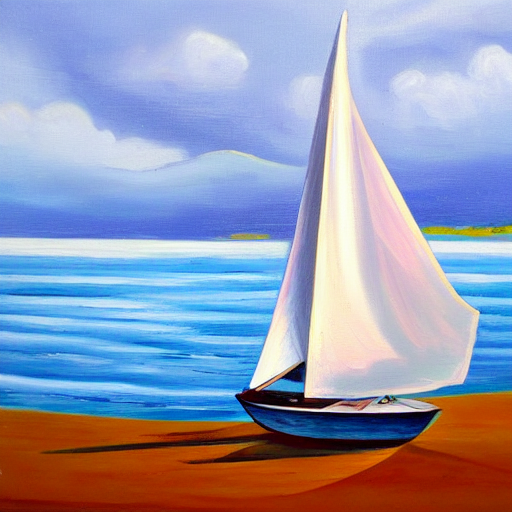

In [ ]:
#@title Store the predicted outputs and next frame for later viewing
prompt = 'A sailing boat (oil on canvas)' #@param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #@param           # Number of denoising steps
guidance_scale = 8 #@param               # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 40 #@param

# Make a folder to store results
!rm -rf steps/
!mkdir -p steps/

# Prep text 
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    #### ADDITIONAL GUIDANCE ###
    # Requires grad on the latents
    latents = latents.detach().requires_grad_()

    # Get the predicted x0:
    latents_x0 = latents - sigma * noise_pred

    # Decode to image space
    denoised_images = vae.decode((1 / 0.18215) * latents_x0) / 2 + 0.5 # (0, 1)

    # Calculate loss
    loss = blue_loss(denoised_images) * blue_loss_scale
    if i%10==0:
      print(i, 'loss:', loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, latents)[0]

    # Modify the latents based on this gradient
    latents = latents.detach() + cond_grad * sigma**2
    

    ### And saving as before ###
    # Get the predicted x0:
    latents_x0 = latents - sigma * noise_pred
    im_t0 = latents_to_pil(latents_x0)[0]

    # And the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]
    im_next = latents_to_pil(latents)[0]

    # Combine the two images and save for later viewing
    im = Image.new('RGB', (1024, 512))
    im.paste(im_next, (0, 0))
    im.paste(im_t0, (512, 0))
    im.save(f'steps/{i:04}.jpeg')

latents_to_pil(latents)[0]

Here's what the output looks like for a few different `blue_loss_scale` valuess:

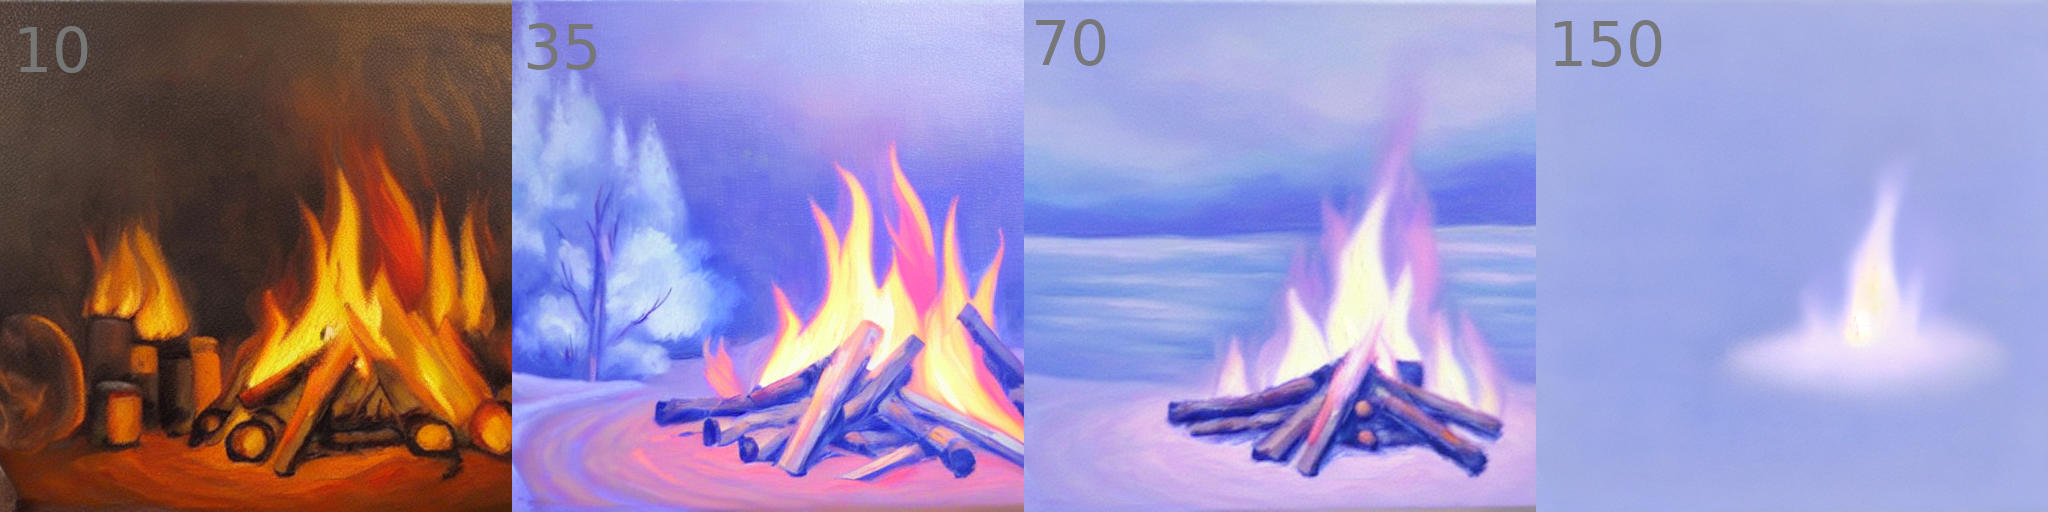

This prompt really doesn't want to be blue, so I had to set the scale quite high. Lower (eg 10) or remove it to check for yourself that this is definitely having an effect on the output - without this extra loss we'd something red/orange and dark. Set it higher (100 or 200) and it starts to overwhelm the process.

How is this working?

The key here:
- We find our predicted output image
- We find our loss based on this
- We get the gradient of this loss WITH RESPECT TO OUR X (the latents)
- We modify the current X based on this gradient

This is 'nudging' the output at each step in a way that reduces our loss. We can control this by scaling the loss (too high and it takes over, too low and it won't affect the process much).

In this example we're finding the loss in image space, which means we need to decode the latents every step and trace gradients back through the AE's decoder. Hence it's pretty slow. At the moment, this is necessary for things like CLIP guidance, perceptual similarity etc. But with a bit of effort we could probably train models that operate directly on these latents for much faster guidance! 

I leave it to you dear reader to fill in a more interesting loss function here. Imagine:

`loss = style_loss + perceptual_loss + masked_color_palette_complexity_loss + does_it_look_like_a_fish_loss + similarity_to_elvis + ...`

You get the idea :)

PS: in this example we set requires grad on the latents AFTER the model makes it's prediction of the noise, so the gradients of our guiding loss get traced back through a fairly simple calculation. Ideally you'dd trace them back through the unet - this gives more accurate gradients but requires a lot more memory. For things like CLIP guidance I'm seeing people converge on doing it the harder way and you may want to try both.

# Conclusions

This is a neat model, and there is a lot we can do with it! I hope this notebook helped you peek under the hood a little more, and that you're inspired to start exploring further and doing some experiments of your own. If you have questions, you can find me on twitter @johnowhitaker or come and join our AIAIART discord (invite link at the bottom of the readme here: https://github.com/johnowhitaker/aiaiart). I'll be announcing a new course soon, so stay tuned for an announcement on that shortly too :)

### PS: This notebook uses a fixed seed for some demos, if you don't want this remove `generator=generator` from anywhere noise is being generated...